# Assembling the Analysis

Goal of this notebook:
* figure out how to do alle the important step
* once everything is running you can implement a script

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

from sklearn.cluster import DBSCAN
from sklearn import metrics

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

import time
import sys
import h5py

from math import pow
from math import ceil

from numba import jit

### Parameters for DBSCAN

Those need a review once everything runs!!

In [2]:
#parameters for DBSCAN
eps=2 #was 5
min_samples=20
algorithm='kd_tree'
n_jobs=-1

### Problem specific parameters

* file name
* density thereshold -> iterate over that?

In [10]:
dens_th = 10
data_file = 'axion.m.10901'

## Get data

Read in the data & process it for the clustering.
Still to do: read the pysical size of the grid from the file

In [11]:
@jit
def numba_pos_data(a_in, th):
    
    n3 = len(a_in)
    n = int(pow(len(data),1./3.)+10**-5)
    n2 = int(n**2)
    nth = len(np.extract(a_in>th,a_in))
    
    print ("points per axis: %d" %n)
          
    a_out = np.zeros((nth,3)) #make this an integer array?
    counter = 0
    
    for index in range(0,n3):
        if a_in[index]> th:
            
            i = index/n2
            j = (index - i*n2)/n
            k = (index%n2)%n
            
            a_out[counter][0] = i
            a_out[counter][1] = j
            a_out[counter][2] = k
            
            counter +=1
            
    return a_out, n, counter

In [12]:
start = time.time()

file = h5py.File(data_file, 'r')
data = file['energy/density'].value
file.close()
data = np.array(data)

end=time.time()
print('gettin the array from file took %1.3f s' %(end-start))

gettin the array from file took 0.642 s


In [13]:
start = time.time()

pos, n, counti = numba_pos_data(data, dens_th)

end=time.time()
print('computing position array with numba took %1.3f s' %(end-start))

points per axis: 512
computing position array with numba took 0.798 s


In [14]:
counti

490560

## Clustering

### Step 1: Ignore periodic boundaries

In [15]:
start = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
labels = np.array(db.labels_)
end = time.time()
print('clustering of the full dataset took %1.3f s' %(end-start))

clustering of the full dataset took 188.740 s


Plotting the whole grid (below). Works but very slow (~3 minutes on my laptop). I think because matplotlib is not too good with large ammounts of data. We won't produce many of these plots anyway, so it's not very crucial.

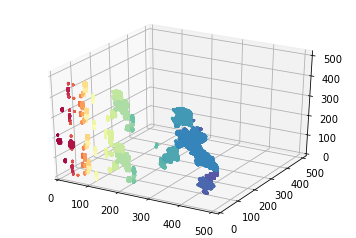

clustering of the full dataset took 46.923 s


In [16]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        #plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6)

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('clustering of the full dataset took %1.3f s' %(end-start))

### step 2: glue together boundaries

The DBSCAN algorithm in principle accepts a user-defined metric, where we could account for periodic boundary conditions. However, that makes the computation super slow!

The following procedure works quite well:
* 1: cut out layers at the boundaries
* 2: addjust the large indices i-> i-n, to account for periodic boundaries
* 3: rerun clustering on the boundaries
* 4: correct in the dataset of the whole grid for the newly found clusters

The only things you need to bee aware of with this procedure are
* there are jumps in the list of cluster labels
* once a point is classified noise it can't be re-assigned to a cluster

In [17]:
def get_borders(pos_in, labels_in, thickness, size):
    
    pos_out = np.empty([0,3])
    labels_out = np.empty([0])
    
    for i in range(0,3):
        mask_u = (pos_in[:,i]<thickness)
        mask_l = (pos_in[:,i]>size-thickness)
        
        layer_u = pos_in[mask_u]
        layer_l = pos_in[mask_l]
        layer_l[:,i] = layer_l[:,i]-size
        
        labels_u = labels_in[mask_u]
        labels_l = labels_in[mask_l]
        
        layer = np.concatenate((layer_u,layer_l))
        labels = np.concatenate((labels_u, labels_l))
        
        pos_out = np.concatenate((pos_out,layer))
        labels_out = np.concatenate((labels_out,labels))
        
    return pos_out, labels_out   

In [18]:
start = time.time()
pos_b, labels_old = get_borders(pos,labels,3,n)
end =time.time()
print('slicing out the borders took %1.3f s' %(end-start))

slicing out the borders took 0.053 s


In [19]:
start = time.time()
db_b = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos_b)
labels_b = np.array(db_b.labels_)
end =time.time()
print('clustering borders took %1.3f s' %(end-start))

clustering borders took 188.975 s


In [20]:
def relabel(l_orig, l_old, l_new):
    
    #loop over all NEW clusters
    for i in set(l_new):
        if not(i==-1):
            #get which OLD labels belong to a new cluster
            mask_old = (l_new == i)
            values_old = set(l_old[mask_old]) 

            #cant assign noise to a cluster
            if -1 in values_old:
                values_old.remove(-1)
                
            #if there is a cluster on the boundary, which doesn't reach over thereshold 
            #on both sides individually the algoritm won't find it    
            if (len(values_old)>0):
                #define one common label for the NEW clsuers
                new_index = min(values_old)
        
                #rename labels in original data
                for index in values_old:
                    l_orig[l_orig==index] = new_index
    
    return l_orig

In [21]:
start = time.time()
labels = relabel(labels, labels_old, labels_b)
end = time.time()
print('relabeling the clusters at the boundaries took %1.3f' %(end-start))

relabeling the clusters at the boundaries took 0.249


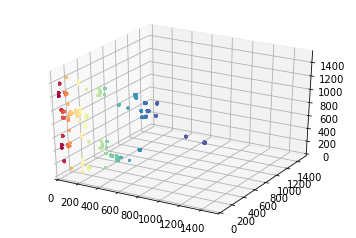

plotting the full dataset took 6.625 s


In [78]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if (k>-1):

        class_member_mask = (labels == k)
        xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

        #plot projection on x-y plane
        #plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markersize=6)

        #3D plot
        #if ( np.size(xyz) > 3*500 ):
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

plt.show()

end = time.time()
print('plotting the full dataset took %1.3f s' %(end-start))

## Analyzing the clusters
Still to do:
* analyze sphericity
* normalize mass

computes for every cluster:
* number of points
* sum of densities -> normalize
* center of mass (com)
* maximum distance to com

In [22]:
def mc_properties (labels, positions, densities):
    
    n_grid = int(pow(len(densities),1./3.)+10**-5)
    n_clusters = len(set(labels))
    
    #this gives back:
    # 0: number of points
    # 1: mass -> To DO: normalize
    # 3: size (=largest distance to com)
    
    mc_data = np.zeros( (3, n_clusters))
    com_list = np.zeros ( (n_clusters,3) )
    counter = 0
    
    
    for i in set(labels):
        mask = (labels==i)
        
        points = pos[mask]
        idx = np.sum(points*np.array([n**2,n,1]),axis=1,dtype=int)
        dens = densities[idx]
        
        n_points = len(idx)
        mass = np.sum(dens)
        com = np.sum(np.multiply(dens,points.transpose()),axis=1)/mass
        
        #account for periodic boundaries and check this works the way you think!
        size = np.amax( np.linalg.norm((points-com) ) )
                
        mc_data[0][counter] = n_points
        mc_data[1][counter] = mass
        mc_data[2][counter] = size
        
        #if(size > np.sqrt(3.*n_grid**2)):
         #   print('Error size too large')
            
        #if(any(com)>n):
         #   print('Error com out of grid')
        
        com_list[counter] = com
        
        counter+=1        
        
    return mc_data, com_list

In [23]:
start = time.time()
mc_dat, com = mc_properties(labels, pos, data)
end = time.time()
print('computing the mass spectrum took %1.3f s' %(end-start))

computing the mass spectrum took 0.318 s


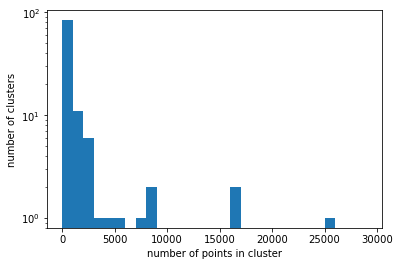

In [24]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('number of points in cluster')
plt.ylabel('number of clusters')
plt.hist(mc_dat[0],bins=np.array(range(0,30000,1000)))
plt.show()

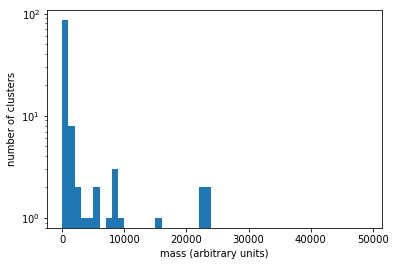

In [25]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('mass (arbitrary units)')
plt.ylabel('number of clusters')
plt.hist(mc_dat[1],bins=np.array(range(0,50000,1000)))
plt.show()

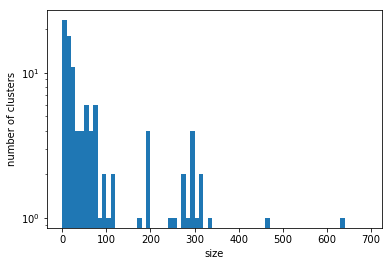

In [26]:
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('size')
plt.ylabel('number of clusters')
plt.hist(mc_dat[2],bins=np.array(range(0,700,10)))
plt.show()

location of COMs in the gris

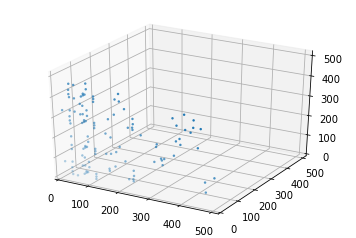

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)

ax.scatter(com[:,0], com[:,1], com[:,2], s=6, lw=0)

plt.show()

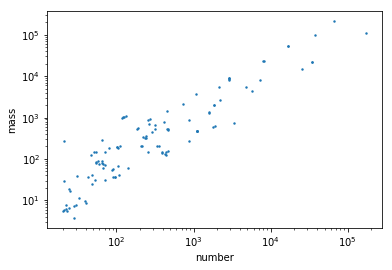

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('number')
plt.ylabel('mass')

plt.yscale('log')
plt.xscale('log')
#plt.xlim(xmin=0,xmax=3e3)
#plt.ylim(ymin=0,ymax=3e4)

ax.scatter(mc_dat[0], mc_dat[1], s=6, lw=0)

plt.show()

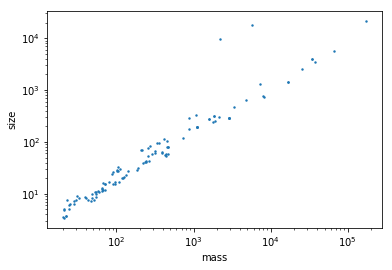

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('mass')
plt.ylabel('size')

plt.yscale('log')
plt.xscale('log')
#plt.xlim(xmin=0,xmax=1e5)
#plt.ylim(ymin=0,ymax=1e4)

ax.scatter(mc_dat[0], mc_dat[2], s=6, lw=0)

plt.show()